In [238]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
from mne.channels import make_standard_montage
from mne.preprocessing import ICA
from mne import create_info
from mne.io import RawArray
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
import math
from tqdm import tqdm
import torch
from typing import Optional
from numpy.typing import ArrayLike
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from braindecode.models import EEGNetv4

In [222]:
base_path = './'
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Function to load a trial's EEG data
def load_trial_data(row, base_path='.'):
    # Determine dataset type based on ID range
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'

    # Construct the path to EEGdata.csv
    eeg_path = os.path.join(base_path, row['task'], dataset, str(row['subject_id']), str(row['trial_session']), 'EEGdata.csv')

    # Load the entire EEG file
    eeg_data = pd.read_csv(eeg_path)

    # Calculate indices for the specific trial
    trial_num = int(row['trial'])
    if row['task'] == 'MI':
        samples_per_trial = 2250  # 9 seconds * 250 Hz
    else:  # SSVEP
        samples_per_trial = 1750  # 7 seconds * 250 Hz

    start_idx = (trial_num - 1) * samples_per_trial
    end_idx = start_idx + samples_per_trial - 1

    # Extract the trial data
    trial_data = eeg_data.iloc[start_idx:end_idx+1]
    return trial_data

In [311]:
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_CHANNELS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
SAMPLE_RATE = 250
BASELINE_THRESHOLD = 0.5
BANDPASS = (6, 28)
CROP_WINDOW = (1, 8)

In [315]:
# --- Signal Processing ---
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def apply_bandpass(data, lowcut, highcut):
    b, a = butter_bandpass(lowcut, highcut, SAMPLE_RATE)
    return lfilter(b, a, data, axis=0)

# --- ICA Cleaning ---
def apply_ica(data, ica_model: Optional[ICA]=None) -> ArrayLike:
    if ica_model is None:
        return data

    info = create_info(ch_names=EEG_CHANNELS, sfreq=SAMPLE_RATE, ch_types='eeg')
    raw = RawArray(data.T, info)

    raw_clean = ica_model.apply(raw.copy())
    return raw_clean.get_data().T

def fit_global_ica(eeg_trials):
    all_data = np.concatenate(eeg_trials, axis=0)  # shape: (total_samples, n_channels)
    channels = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    info = create_info(ch_names=channels, sfreq=SAMPLE_RATE, ch_types="eeg")
    info.set_montage(make_standard_montage('standard_1020'))
    raw = RawArray(all_data.T, info)

    ica = ICA(n_components=len(channels), random_state=42, max_iter="auto")
    ica.fit(raw)
    ica.plot_components()
    return ica

def crop_data(data):
    start_idx = CROP_WINDOW[0] * SAMPLE_RATE
    end_idx = CROP_WINDOW[1] * SAMPLE_RATE
    return data[math.floor(start_idx):math.floor(end_idx)]

def preprocess_trial(trial_df: pd.DataFrame, ica_model=None) -> tuple:
    eeg = trial_df[EEG_CHANNELS].values  # (T, C_eeg)
    motion = trial_df[MOTION_CHANNELS].values  # (T, C_motion)

    eeg = apply_bandpass(eeg, *BANDPASS)

    baseline_samples = int(BASELINE_THRESHOLD * SAMPLE_RATE)
    eeg_baseline = np.mean(eeg[:baseline_samples], axis=0)
    eeg -= eeg_baseline

    if ica_model is not None:
        channels = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
        info = create_info(ch_names=channels, sfreq=SAMPLE_RATE, ch_types="eeg")
        raw = RawArray(eeg.T, info)
        ica_model.exclude = [1, 4]
        raw_clean = ica_model.apply(raw.copy())
        eeg = raw_clean.get_data().T

    eeg = crop_data(eeg)
    motion = crop_data(motion)
    
    eeg = (eeg - np.mean(eeg, axis=0)) / (np.std(eeg, axis=0) + 1e-6)
    motion = (motion - np.mean(motion, axis=0)) / (np.std(motion, axis=0) + 1e-6)

    return eeg.T, motion.T

In [309]:
def load_training_eeg_trials(df):
    eeg_trials = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading EEG trials"):
        trial_df = load_trial_data(row)
        eeg_trials.append(trial_df[EEG_CHANNELS].values)

    return eeg_trials

In [226]:
train_eeg_trials = load_training_eeg_trials(train_df[:2400])

Loading EEG trials: 100%|██████████| 2400/2400 [03:39<00:00, 10.95it/s]


Creating RawArray with float64 data, n_channels=8, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)


C:\Users\2024\AppData\Local\Temp\ipykernel_1300\3664221466.py:30: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 8 components
Fitting ICA took 64.9s.


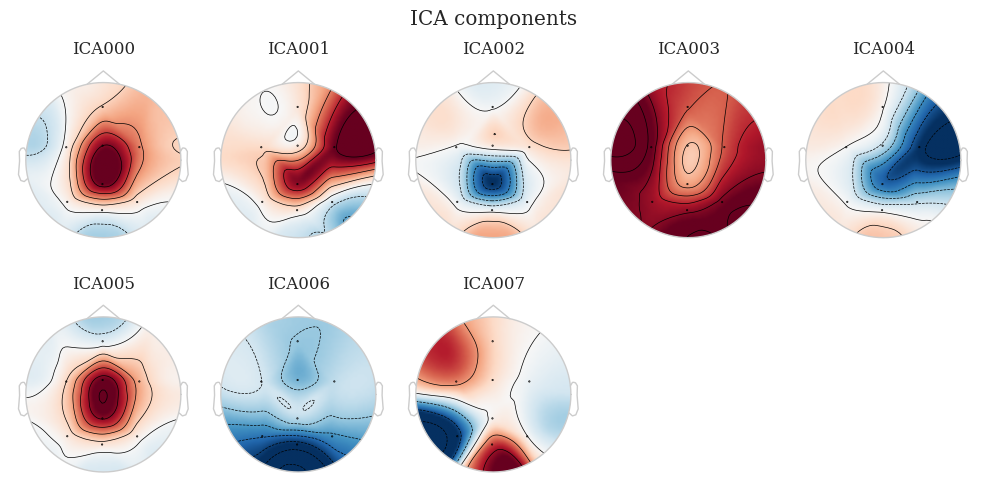

In [252]:
ica_model = fit_global_ica(train_eeg_trials)

In [310]:
def preprocess_data(df, ica_model=None, test_data=False):
    X_eeg, X_motion, y = [], [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preprocessing Trials"):
        try:
            trial_df = load_trial_data(row)
            eeg, motion = preprocess_trial(trial_df, ica_model)

            X_eeg.append(eeg)
            X_motion.append(motion)

            if not test_data:
                label = 0 if row["label"] == "Left" else 1
                y.append(label)

        except Exception as e:
            print(f"Trial {idx} skipped due to error: {e}")

    X_eeg = torch.tensor(np.stack(X_eeg), dtype=torch.float32)
    X_motion = torch.tensor(np.stack(X_motion), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.long)

    return X_eeg, X_motion, y

In [313]:
X_train_eeg, X_train_motion, y_train = preprocess_data(train_df[:2400])

Preprocessing Trials: 100%|██████████| 2400/2400 [03:30<00:00, 11.39it/s]


In [314]:
X_val_eeg, X_val_motion, y_val = preprocess_data(validation_df[:50], ica_model)

Preprocessing Trials:   0%|          | 0/50 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   2%|▏         | 1/50 [00:00<00:07,  6.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   4%|▍         | 2/50 [00:00<00:06,  7.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   6%|▌         | 3/50 [00:00<00:05,  8.65it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   8%|▊         | 4/50 [00:00<00:06,  6.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  10%|█         | 5/50 [00:00<00:05,  7.61it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  12%|█▏        | 6/50 [00:00<00:06,  7.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  14%|█▍        | 7/50 [00:00<00:06,  7.00it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  16%|█▌        | 8/50 [00:01<00:06,  6.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  18%|█▊        | 9/50 [00:01<00:06,  6.38it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  20%|██        | 10/50 [00:01<00:06,  6.25it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  22%|██▏       | 11/50 [00:01<00:06,  6.14it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  24%|██▍       | 12/50 [00:01<00:05,  6.51it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  26%|██▌       | 13/50 [00:01<00:05,  7.09it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  28%|██▊       | 14/50 [00:01<00:04,  7.41it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  30%|███       | 15/50 [00:02<00:04,  7.49it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  32%|███▏      | 16/50 [00:02<00:04,  7.52it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  34%|███▍      | 17/50 [00:02<00:04,  7.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  36%|███▌      | 18/50 [00:02<00:04,  7.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  38%|███▊      | 19/50 [00:02<00:03,  7.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  40%|████      | 20/50 [00:02<00:03,  7.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  42%|████▏     | 21/50 [00:02<00:04,  7.12it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  44%|████▍     | 22/50 [00:03<00:04,  6.77it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  46%|████▌     | 23/50 [00:03<00:04,  6.63it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  48%|████▊     | 24/50 [00:03<00:04,  6.23it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  50%|█████     | 25/50 [00:03<00:03,  6.44it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  52%|█████▏    | 26/50 [00:03<00:03,  7.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  54%|█████▍    | 27/50 [00:03<00:03,  7.51it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  56%|█████▌    | 28/50 [00:03<00:02,  8.10it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  58%|█████▊    | 29/50 [00:03<00:02,  8.59it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  60%|██████    | 30/50 [00:04<00:02,  8.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  62%|██████▏   | 31/50 [00:04<00:02,  7.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  64%|██████▍   | 32/50 [00:04<00:02,  7.86it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  66%|██████▌   | 33/50 [00:04<00:02,  7.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  68%|██████▊   | 34/50 [00:04<00:02,  7.89it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  70%|███████   | 35/50 [00:04<00:01,  7.93it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  72%|███████▏  | 36/50 [00:04<00:01,  7.72it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  74%|███████▍  | 37/50 [00:05<00:01,  7.16it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  76%|███████▌  | 38/50 [00:05<00:01,  7.19it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  78%|███████▊  | 39/50 [00:05<00:01,  7.56it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  80%|████████  | 40/50 [00:05<00:01,  7.82it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  82%|████████▏ | 41/50 [00:05<00:01,  7.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  84%|████████▍ | 42/50 [00:05<00:01,  7.97it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  86%|████████▌ | 43/50 [00:05<00:00,  7.26it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  88%|████████▊ | 44/50 [00:06<00:00,  6.55it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  90%|█████████ | 45/50 [00:06<00:00,  6.04it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  92%|█████████▏| 46/50 [00:06<00:00,  6.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  94%|█████████▍| 47/50 [00:06<00:00,  6.36it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  96%|█████████▌| 48/50 [00:06<00:00,  6.64it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  98%|█████████▊| 49/50 [00:06<00:00,  6.43it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


In [316]:
X_full_eeg = torch.cat([X_train_eeg, X_val_eeg], dim=0)
X_full_motion = torch.cat([X_train_motion, X_val_motion], dim=0)
y_full = torch.cat([y_train, y_val], dim=0)

In [317]:
# def extract_csp_features(X_list, y_list, n_components=4, for_deep_learning=False):
#     X = np.array(X_list)  # shape: (n_trials, n_channels, n_samples)
#     y = np.array(y_list)

#     if for_deep_learning:
#         csp = CSP(n_components, transform_into='csp_space')
#     else:
#         csp = CSP(n_components, transform_into='average_power', log=True)

#     X_csp = csp.fit_transform(X, y)
#     return X_csp, csp

In [318]:
# def compare_eeg_preprocessing(original_df: pd.DataFrame, processed_df: pd.DataFrame, channels=None, sample_rate=250, seconds=5):
#     """
#     Plot original vs preprocessed EEG signals for selected channels and duration.
#     """
#     if channels is None:
#         channels = ['C3', 'CZ', 'C4']

#     n_samples = sample_rate * seconds
#     time = np.arange(n_samples) / sample_rate

#     fig, axs = plt.subplots(len(channels), 1, figsize=(12, 2.5 * len(channels)), sharex=True)

#     for idx, ch in enumerate(channels):
#         axs[idx].plot(time, original_df[ch][:n_samples], label='Original', alpha=0.7)
#         axs[idx].plot(time, processed_df[ch][:n_samples], label='Preprocessed', alpha=0.7)
#         axs[idx].set_title(f"Channel: {ch}")
#         axs[idx].legend(loc='upper right')
#         axs[idx].set_ylabel('Amplitude (μV)')

#     axs[-1].set_xlabel('Time (s)')
#     plt.tight_layout()
#     plt.suptitle("EEG Signal Before vs After Preprocessing", fontsize=16, y=1.02)
#     plt.show()

In [319]:
# trial_data = load_trial_data(train_df.iloc[0], base_path)
# preprocessed = preprocess_trial(trial_data)
# compare_eeg_preprocessing(normalize_for_plot(trial_data), preprocessed)

In [482]:
class EEGMotionNet(nn.Module):
    def __init__(self, in_chans_eeg, in_chans_motion, input_window_samples, n_classes):
        super().__init__()

        self.spatial_dropout = nn.Dropout1d(p=0.2)

        self.eeg_net = EEGNetv4(
            n_chans=in_chans_eeg,
            n_times=input_window_samples,
            n_outputs=n_classes
        )

        # self.motion_net = nn.Sequential(
        #     nn.Conv1d(in_chans_motion, 16, kernel_size=5, stride=2),
        #     nn.ReLU(),
        #     nn.AdaptiveAvgPool1d(1),
        #     nn.Flatten()
        # )

        # self.fusion = nn.Sequential(
        #     nn.Linear(n_classes + 16, 64),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),
        #     nn.Linear(64, n_classes)
        # )

    def forward(self, x_eeg, x_motion):
        x_eeg = self.spatial_dropout(x_eeg)
        eeg_out = self.eeg_net(x_eeg)
        # motion_out = self.motion_net(x_motion)
        # fused = torch.cat([eeg_out, motion_out], dim=1)
        return eeg_out
        # self.fusion(fused)


In [483]:
window_samples = math.floor((CROP_WINDOW[1] - CROP_WINDOW[0]) * SAMPLE_RATE)
model = EEGMotionNet(
    in_chans_eeg=len(EEG_CHANNELS),
    in_chans_motion=len(MOTION_CHANNELS),
    input_window_samples=window_samples,
    n_classes=2
)

In [484]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)
X_train_eeg = X_train_eeg.to(device)
X_train_motion = X_train_motion.to(device)
y_train = y_train.to(device)

Using device: cpu


In [485]:
dataset = TensorDataset(X_train_eeg, X_train_motion, y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_eeg, X_val_motion, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [486]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)
print(f"Parameters to train: {sum(p.numel() for p in model.parameters())}")

Parameters to train: 2962


In [488]:
def train_model(model, dataloader, val_loader, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for x_eeg, x_motion, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(x_eeg, x_motion)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(dataloader)

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []

        with torch.no_grad():
            for x_eeg_val, x_motion_val, labels_val in val_loader:
                val_outputs = model(x_eeg_val, x_motion_val)
                loss = criterion(val_outputs, labels_val)
                val_loss += loss.item()

                preds = torch.argmax(val_outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels_val.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds)
        print(f"Epoch {epoch+1:02}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f} | Val F1: {val_f1:.2f}")

    return model


In [489]:
best_model = train_model(model, dataloader, val_loader, criterion, optimizer)

Epoch 01/30 | Train Loss: 0.7612 | Val Loss: 0.7114 | Val Acc: 0.44 | Val F1: 0.61
Epoch 02/30 | Train Loss: 0.7091 | Val Loss: 0.6894 | Val Acc: 0.46 | Val F1: 0.47
Epoch 03/30 | Train Loss: 0.6881 | Val Loss: 0.7115 | Val Acc: 0.52 | Val F1: 0.61
Epoch 04/30 | Train Loss: 0.6823 | Val Loss: 0.6817 | Val Acc: 0.54 | Val F1: 0.47
Epoch 05/30 | Train Loss: 0.6855 | Val Loss: 0.6666 | Val Acc: 0.56 | Val F1: 0.52
Epoch 06/30 | Train Loss: 0.6599 | Val Loss: 0.6766 | Val Acc: 0.64 | Val F1: 0.50
Epoch 07/30 | Train Loss: 0.6645 | Val Loss: 0.6906 | Val Acc: 0.58 | Val F1: 0.55
Epoch 08/30 | Train Loss: 0.6682 | Val Loss: 0.6880 | Val Acc: 0.58 | Val F1: 0.36
Epoch 09/30 | Train Loss: 0.6621 | Val Loss: 0.7199 | Val Acc: 0.48 | Val F1: 0.41
Epoch 10/30 | Train Loss: 0.6543 | Val Loss: 0.7733 | Val Acc: 0.52 | Val F1: 0.45
Epoch 11/30 | Train Loss: 0.6611 | Val Loss: 0.7101 | Val Acc: 0.56 | Val F1: 0.48
Epoch 12/30 | Train Loss: 0.6423 | Val Loss: 0.7111 | Val Acc: 0.48 | Val F1: 0.48
Epoc

In [501]:
torch.save(best_model.state_dict(), os.path.join("models", 'eegnet_trained.pth'))
print("Model trained and saved as 'eegnet_trained.pth'")

Model trained and saved as 'eegnet_trained.pth'


In [502]:
X_test_eeg, X_test_motion, _ = preprocess_data(test_df[:50], ica_model, test_data=True)

Preprocessing Trials:   0%|          | 0/50 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   2%|▏         | 1/50 [00:00<00:08,  5.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   4%|▍         | 2/50 [00:00<00:07,  6.31it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:   8%|▊         | 4/50 [00:00<00:05,  8.47it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  10%|█         | 5/50 [00:00<00:05,  8.88it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  14%|█▍        | 7/50 [00:00<00:04,  9.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  16%|█▌        | 8/50 [00:00<00:04,  9.78it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  20%|██        | 10/50 [00:01<00:03, 10.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  24%|██▍       | 12/50 [00:01<00:03,  9.71it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  26%|██▌       | 13/50 [00:01<00:03,  9.76it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  30%|███       | 15/50 [00:01<00:03,  9.54it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  32%|███▏      | 16/50 [00:01<00:03,  9.42it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  36%|███▌      | 18/50 [00:01<00:03,  9.55it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  38%|███▊      | 19/50 [00:02<00:03,  9.05it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  40%|████      | 20/50 [00:02<00:03,  8.92it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  42%|████▏     | 21/50 [00:02<00:03,  8.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  44%|████▍     | 22/50 [00:02<00:03,  8.80it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  46%|████▌     | 23/50 [00:02<00:03,  8.64it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  48%|████▊     | 24/50 [00:02<00:02,  8.81it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  50%|█████     | 25/50 [00:02<00:02,  9.01it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  54%|█████▍    | 27/50 [00:02<00:02,  9.55it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  56%|█████▌    | 28/50 [00:03<00:02,  9.06it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  58%|█████▊    | 29/50 [00:03<00:02,  8.79it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  60%|██████    | 30/50 [00:03<00:02,  8.40it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  62%|██████▏   | 31/50 [00:03<00:02,  8.57it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  64%|██████▍   | 32/50 [00:03<00:02,  6.73it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  66%|██████▌   | 33/50 [00:03<00:02,  6.85it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  68%|██████▊   | 34/50 [00:03<00:02,  7.20it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  70%|███████   | 35/50 [00:04<00:01,  7.57it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  72%|███████▏  | 36/50 [00:04<00:01,  8.13it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  74%|███████▍  | 37/50 [00:04<00:01,  8.54it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  76%|███████▌  | 38/50 [00:04<00:01,  8.59it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  78%|███████▊  | 39/50 [00:04<00:01,  8.66it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  82%|████████▏ | 41/50 [00:04<00:01,  8.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  84%|████████▍ | 42/50 [00:04<00:00,  8.98it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  86%|████████▌ | 43/50 [00:04<00:00,  8.87it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  88%|████████▊ | 44/50 [00:05<00:00,  8.94it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  92%|█████████▏| 46/50 [00:05<00:00,  9.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  94%|█████████▍| 47/50 [00:05<00:00,  9.15it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials:  98%|█████████▊| 49/50 [00:05<00:00,  9.32it/s]

Creating RawArray with float64 data, n_channels=8, n_times=2250
    Range : 0 ... 2249 =      0.000 ...     8.996 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


Preprocessing Trials: 100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


In [504]:
saved_module = EEGMotionNet(
    in_chans_eeg=len(EEG_CHANNELS),
    in_chans_motion=len(MOTION_CHANNELS),
    input_window_samples=window_samples,
    n_classes=2
)

saved_module.load_state_dict(torch.load(os.path.join("models", 'eegnet_trained.pth')))
saved_module.eval()

EEGMotionNet(
  (spatial_dropout): Dropout1d(p=0.2, inplace=False)
  (eeg_net): EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Rearrange('batch ch t 1 -> batch 1 ch t')
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv_spatial): Conv2dWithConstraint(8, 16, kernel_size=(8, 1), stride=(1, 1), groups=8, bias=False)
    (bnorm_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_1): Expression(expression=elu) 
    (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (drop_1): Dropout(p=0.25, inplace=False)
    (conv_separable_depth): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (conv_separable_point): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(16, eps=0.001, momentum=0.01

In [505]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_test_eeg = X_test_eeg.to(device)
X_test_motion = X_test_motion.to(device)

In [506]:
with torch.no_grad():
    outputs = model(X_test_eeg, X_test_motion)
    predictions = torch.argmax(outputs, dim=1)

In [507]:
def save_predictions(y_pred: Tensor, test_df: pd.DataFrame, filename: str):
    # map y_pred to left or right
    preds = y_pred.cpu().numpy()
    labels = np.where(preds == 0, "Left", "Right")

    # create a dataframe with the predictions and the actual labels
    predictions_df = pd.DataFrame({
        "label": labels
    })

    predictions_df["id"] = test_df["id"]
    predictions_df = predictions_df[["id", "label"]]
    predictions_df.to_csv(f'submissions/{filename}_submission.csv', index=False)

In [508]:
save_predictions(predictions, test_df, "eegnet")

In [481]:

# def svm_pipeline(X_train, y_train, X_test):
#     clf_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', SVC(kernel='rbf', C=1, gamma=0.01))
#     ])

#     clf_pipeline.fit(X_train, y_train)
#     # param_grid = {
#     #     'classifier__C': [0.1, 1, 10],
#     #     'classifier__gamma': [0.01, 0.1, 1]
#     # }

#     # grid = GridSearchCV(clf_pipeline, param_grid, cv=5)
#     # grid.fit(X_train, y_train)
#     return clf_pipeline.predict(X_test)

# def lda_pipeline(X_train, y_train, X_test):
#     clf_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('classifier', LDA())
#     ])
#     clf_pipeline.fit(X_train, y_train)
#     return clf_pipeline.predict(X_test)

# y_pred_svm = svm_pipeline(X_train_csp, y_train, X_val_csp)
# y_pred_lda = lda_pipeline(X_train_csp, y_train, X_val_csp)

In [26]:
# acc = accuracy_score(y_val, y_pred_svm)
# f1 = f1_score(y_val, y_pred_svm)

# print("Accuracy: ", acc)
# print("F1: ", f1)

In [27]:
# save_predictions(y_pred_lda, test_df, "lda")

In [28]:
# save_predictions(y_pred_svm, test_df, "svm")